In [9]:
from joblib import load
import numpy as np
import pandas as pd
import spacy
import re
from fractions import Fraction
from decimal import Decimal, InvalidOperation
import unicodedata
import sys
sys.path.append("..")
from src.data import data_cleaning_util
from src.features import create_features

In [15]:
# Load our trained CRF model and the spacy NLP Model
crf = load('../models/crf_model.joblib')
nlp = spacy.load('en_core_web_lg', disable=['ner','textcat'])

In [83]:
epi_raw = pd.read_json("../data/raw/recipes_raw_epi.json")

In [84]:
epi_raw.head()

,http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,http://www.epicurious.com/recipes/food/views/-burnt-carrots-and-parsnips-56390131,http://www.epicurious.com/recipes/food/views/-california-roll-salad-12246,http://www.epicurious.com/recipes/food/views/-candy-corn-frozen-citrus-cream-pops-368770,http://www.epicurious.com/recipes/food/views/-candy-corn-pumpkin-blondies-51254510,http://www.epicurious.com/recipes/food/views/-cannoli-ice-cream-sandwiches-242004,...,http://www.epicurious.com/recipes/food/views/zucchini-wrapped-red-snapper-with-tomato-cumin-and-orange-sauce-10045,http://www.epicurious.com/recipes/food/views/zuni-ricotta-gnocchi-241532,http://www.epicurious.com/recipes/food/views/zuni-roast-chicken-with-bread-salad-56389456,http://www.epicurious.com/recipes/food/views/zuni-rolls-with-raspberry-chipotle-sauce-15259,http://www.epicurious.com/recipes/food/views/zuppa-di-cavolo-nero-cannellini-e-salsicce-kale-white-bean-and-sausage-soup-363386,http://www.epicurious.com/recipes/food/views/zuppa-inglese-394,http://www.epicurious.com/recipes/food/views/zwetschgenkuchen-14600,http://www.epicurious.com/recipes/seared-scallops-with-tomato-water-lime-and-mint-51242060-recipe,http://www.epicurious.com/simple-syrup-368889-recipe,http://www.epicurious.com/suzanne-goin-s-corned-beef-and-cabbage-with-parsley-mustard-sauce-56389323-recipe
avg_rating,2.5,3.5,3,4,3.5,3.5,3.5,2,3,3,...,3,3,4,3.5,3.5,4,3,None,None,None
best_rating,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,None,None,None
ingredients,"[2 or 3 large garlic cloves, a 2-ounce jar dic...","[1/4 cup (1/2 stick) unsalted butter, 4-5 medi...","[8 small Japanese eggplants, peeled, 16 large ...","[1 lemon, zested, juiced, 1/2 shallot, finely ...","[6 small zucchini, 2 teaspoons salt, 2 cups pa...","[1 1/2 pounds carrots, peeled, halved lengthwi...","[1 1/2 cups long-grain rice, 1/4 cup plus 3 ta...","[2 (14-ounce) cans sweetened condensed milk, 1...","[1 cup (2 sticks) cold unsalted butter, plus m...","[3/4 cup whole-milk ricotta, 1/4 cup cream che...",...,"[2 teaspoons cumin seeds, four 6- to 7-ounce r...","[1 pound fresh ricotta (2 cups), 2 large cold ...","[One small chicken, 2 3/4 to 3 1/2 pounds, 4 t...",[1 cup fresh raspberries or frozen unsweetened...,"[2 Italian sausages, skins removed and meat cr...","[4 cups milk (do not use low-fat or nonfat), 1...","[1 cup unbleached all-purpose flour, dash of s...",[],[],[]
instructions,Force garlic through a garlic press into a lar...,Melt butter in a large heavy skillet over medi...,Place eggplants on double thickness of paper t...,"Combine lemon zest, lemon juice, shallot, toma...",Cut zucchini crosswise into 1/8-inch-thick sli...,"Preheat oven to 450°F. Toss carrots, parsnips,...",Into a large saucepan of salted boiling water ...,"Put one can of milk in each of 2 bowls, then w...",Preheat oven to 350°F. Lightly butter a 9- by ...,Stir together all ingredients except chocolate...,...,Preheat oven to 450°F.\nIn a small dry heavy s...,Check the cheese for wetness. If you are lucky...,Remove and discard the lump of fat inside the ...,In a small saucepan combine sauce ingredients ...,Sauté the crumbled sausage in the oil until br...,Bring milk and 1/2 cup plus 3 tablespoons suga...,"To make the crust using a food processor, fitt...",,,
num_reviews,25,3,4,2,48,2,83,1,15,1,...,8,14,4,47,14,7,6,None,None,None


In [153]:
# We need to transpose the matrix so that we have a the recipes as rows and ingredients as columns
epi_data = epi_raw.transpose()

# Select a subset so processing happend faster
epi_data = epi_data.head(1000)
epi_data.head()

,avg_rating,best_rating,ingredients,instructions,num_reviews,prepare_again_rating,tags,title,total_time,worst_rating,yields
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s)
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,3.5,4,"[1/4 cup (1/2 stick) unsalted butter, 4-5 medi...",Melt butter in a large heavy skillet over medi...,3,0.67,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",0,0,6 item(s)
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,3,4,"[8 small Japanese eggplants, peeled, 16 large ...",Place eggplants on double thickness of paper t...,4,0.75,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant",0,0,4 serving(s)
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,4,4,"[1 lemon, zested, juiced, 1/2 shallot, finely ...","Combine lemon zest, lemon juice, shallot, toma...",2,1,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor...",0,0,6 serving(s)
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,3.5,4,"[6 small zucchini, 2 teaspoons salt, 2 cups pa...",Cut zucchini crosswise into 1/8-inch-thick sli...,48,0.93,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini",0,0,4 serving(s)


In [154]:
# Drop rows with empty ingredients
num_rows = epi_data.shape[0]
epi_data = epi_data[epi_data.astype(str)['ingredients'] != '[]']
print("Dropped {} rows with no ingredients".format(num_rows - epi_data.shape[0]))

Dropped 1 rows with no ingredients


In [155]:
# We do two things next, we create a new dataframe to contain all the ingredient info
# and rearrange it so that it has one ingredient per row. All the non-ingredient columns
# are kept in the original dataframe.
ingredients = epi_data['ingredients'].apply(pd.Series, 1).stack()
ingredients.index = ingredients.index.droplevel(-1)
ingredients.name = 'input'
epi_ingredients = epi_data.join(ingredients)
epi_ingredients.head()

,avg_rating,best_rating,ingredients,instructions,num_reviews,prepare_again_rating,tags,title,total_time,worst_rating,yields,input
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),2 or 3 large garlic cloves
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),a 2-ounce jar diced pimientos
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),3 cups coarsely grated sharp Cheddar (preferab...
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),1/3 to 1/2 cup mayonnaise
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),crackers


In [156]:
# Drop non ingredient/yield columns from ingredient dataframe
epi_ingredients = epi_ingredients[["input","yields"]]
epi_ingredients.head()

,input,yields
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2 or 3 large garlic cloves,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,a 2-ounce jar diced pimientos,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,3 cups coarsely grated sharp Cheddar (preferab...,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,1/3 to 1/2 cup mayonnaise,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,crackers,2 item(s)


In [157]:
 # Drop ingredient/yield columns from data dataframe
del epi_data["ingredients"]
del epi_data["yields"]
epi_data.head()

,avg_rating,best_rating,instructions,num_reviews,prepare_again_rating,tags,title,total_time,worst_rating
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,3.5,4,Melt butter in a large heavy skillet over medi...,3,0.67,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",0,0
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,3,4,Place eggplants on double thickness of paper t...,4,0.75,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant",0,0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,4,4,"Combine lemon zest, lemon juice, shallot, toma...",2,1,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor...",0,0
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,3.5,4,Cut zucchini crosswise into 1/8-inch-thick sli...,48,0.93,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini",0,0


In [158]:
def process_data(input_data):
    # Remove random HTML tags
    input_data = input_data.apply(data_cleaning_util.clean_html, axis=1)

    # Drop rows that have no input
    input_data.dropna(axis=0, subset=["input"], inplace=True)

    # Unicode has numerous characters to represent fractions like ¾, we remove these
    input_data["input"] = input_data["input"].apply(data_cleaning_util.clean_unicode_fractions)

    # Many ingredient quantities are written as 1 1/2 to represent 1.5
    # The quantity label however is always written as 1.5 so we need to
    # convert these fractions so that the crf can match it
    input_data["input"] = input_data["input"].apply(data_cleaning_util.merge_fractions)

    input_data = input_data.apply(data_cleaning_util.fix_abbreviations, axis=1)

    return input_data

In [159]:
# Clean the ingredients
epi_ingredients = process_data(epi_ingredients)
epi_ingredients.head()

,input,yields
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2 or 3 large garlic cloves,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,a 2-ounce jar diced pimientos,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,3 cups coarsely grated sharp Cheddar (preferab...,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.333 to 0.333 cup mayonnaise,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,crackers,2 item(s)


In [160]:
def word2features(sent, i):

    features = {
        "bias": 1.0,
        "lemma": sent[i].lemma_,
        "pos": sent[i].pos_,
        "tag": sent[i].tag_,
        "dep": sent[i].dep_,
        "shape": sent[i].shape_,
        "is_alpha": sent[i].is_alpha,
        "is_stop": sent[i].is_stop,
        "is_title": sent[i].is_title,
        "is_punct": sent[i].is_punct,
    }
    if i > 0:
        features.update(
            {
                "-1:lemma": sent[i - 1].lemma_,
                "-1:pos": sent[i - 1].pos_,
                "-1:tag": sent[i - 1].tag_,
                "-1:dep": sent[i - 1].dep_,
                "-1:shape": sent[i - 1].shape_,
                "-1:is_alpha": sent[i - 1].is_alpha,
                "-1:is_stop": sent[i - 1].is_stop,
                "-1:is_title": sent[i - 1].is_title,
                "-1:is_left_punct": sent[i - 1].is_left_punct,
            }
        )
        if i > 1:
            features.update(
                {
                    "-2:lemma": sent[i - 2].lemma_,
                    "-2:pos": sent[i - 2].pos_,
                    "-2:tag": sent[i - 2].tag_,
                    "-2:dep": sent[i - 2].dep_,
                    "-2:shape": sent[i - 2].shape_,
                    "-2:is_alpha": sent[i - 2].is_alpha,
                    "-2:is_stop": sent[i - 2].is_stop,
                    "-2:is_title": sent[i - 2].is_title,
                    "-2:is_left_punct": sent[i - 2].is_left_punct,
                }
            )
    else:
        features["BOS"] = True

    if i < len(sent) - 1:
        features.update(
            {
                "+1:lemma": sent[i + 1].lemma_,
                "+1:pos": sent[i + 1].pos_,
                "+1:tag": sent[i + 1].tag_,
                "+1:dep": sent[i + 1].dep_,
                "+1:shape": sent[i + 1].shape_,
                "+1:is_alpha": sent[i + 1].is_alpha,
                "+1:is_stop": sent[i + 1].is_stop,
                "+1:is_title": sent[i + 1].is_title,
                "+1:is_right_punct": sent[i + 1].is_right_punct,
            }
        )
        if i < len(sent) - 2:
            features.update(
                {
                    "+2:lemma": sent[i + 2].lemma_,
                    "+2:pos": sent[i + 2].pos_,
                    "+2:tag": sent[i + 2].tag_,
                    "+2:dep": sent[i + 2].dep_,
                    "+2:shape": sent[i + 2].shape_,
                    "+2:is_alpha": sent[i + 2].is_alpha,
                    "+2:is_stop": sent[i + 2].is_stop,
                    "+2:is_title": sent[i + 2].is_title,
                    "+2:is_right_punct": sent[i + 2].is_right_punct,
                }
            )
    else:
        features["EOS"] = True

    return features

In [161]:
# have spacy parse the input string with the full pipeline to generate features this will take some time
epi_ingredients["input"] = list(
        nlp.pipe(epi_ingredients["input"].astype("unicode").values, batch_size=50)
    )


# Create our features dict
epi_ingredients["features"] = epi_ingredients["input"].apply(
    lambda doc: [word2features(doc, i) for i in range(len(doc))]
)
epi_ingredients.head()

,input,yields,features
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(2, or, 3, large, garlic, cloves)",2 item(s),"[{'bias': 1.0, 'lemma': '2', 'pos': 'NUM', 'ta..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(a, 2-ounce, jar, diced, pimientos)",2 item(s),"[{'bias': 1.0, 'lemma': 'a', 'pos': 'DET', 'ta..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(3, cups, coarsely, grated, sharp, Cheddar, (,...",2 item(s),"[{'bias': 1.0, 'lemma': '3', 'pos': 'X', 'tag'..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(0.333, to, 0.333, cup, mayonnaise)",2 item(s),"[{'bias': 1.0, 'lemma': '0.333', 'pos': 'NUM',..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,(crackers),2 item(s),"[{'bias': 1.0, 'lemma': 'cracker', 'pos': 'NOU..."


In [162]:
epi_ingredients["predicted"] = crf.predict(epi_ingredients["features"].values)
epi_ingredients.head()

,input,yields,features,predicted
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(2, or, 3, large, garlic, cloves)",2 item(s),"[{'bias': 1.0, 'lemma': '2', 'pos': 'NUM', 'ta...","[B-QTY, B-COMMENT, I-COMMENT, I-COMMENT, B-NAM..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(a, 2-ounce, jar, diced, pimientos)",2 item(s),"[{'bias': 1.0, 'lemma': 'a', 'pos': 'DET', 'ta...","[B-COMMENT, I-COMMENT, I-COMMENT, I-COMMENT, B..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(3, cups, coarsely, grated, sharp, Cheddar, (,...",2 item(s),"[{'bias': 1.0, 'lemma': '3', 'pos': 'X', 'tag'...","[B-QTY, B-UNIT, B-NAME, I-NAME, I-NAME, I-NAME..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(0.333, to, 0.333, cup, mayonnaise)",2 item(s),"[{'bias': 1.0, 'lemma': '0.333', 'pos': 'NUM',...","[B-OTHER, I-OTHER, I-OTHER, B-UNIT, B-NAME]"
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,(crackers),2 item(s),"[{'bias': 1.0, 'lemma': 'cracker', 'pos': 'NOU...",[B-NAME]


In [163]:
epi_ingredients["input"] = epi_ingredients["input"].apply(lambda doc: [token.lemma_ for token in doc])
epi_ingredients.head()

,input,yields,features,predicted
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"[2, or, 3, large, garlic, clove]",2 item(s),"[{'bias': 1.0, 'lemma': '2', 'pos': 'NUM', 'ta...","[B-QTY, B-COMMENT, I-COMMENT, I-COMMENT, B-NAM..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"[a, 2-ounce, jar, dice, pimiento]",2 item(s),"[{'bias': 1.0, 'lemma': 'a', 'pos': 'DET', 'ta...","[B-COMMENT, I-COMMENT, I-COMMENT, I-COMMENT, B..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"[3, cup, coarsely, grated, sharp, Cheddar, (, ...",2 item(s),"[{'bias': 1.0, 'lemma': '3', 'pos': 'X', 'tag'...","[B-QTY, B-UNIT, B-NAME, I-NAME, I-NAME, I-NAME..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"[0.333, to, 0.333, cup, mayonnaise]",2 item(s),"[{'bias': 1.0, 'lemma': '0.333', 'pos': 'NUM',...","[B-OTHER, I-OTHER, I-OTHER, B-UNIT, B-NAME]"
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,[cracker],2 item(s),"[{'bias': 1.0, 'lemma': 'cracker', 'pos': 'NOU...",[B-NAME]


In [164]:
def smartJoin(words):
    """
    Joins list of words with spaces, but is smart about not adding spaces
    before commas.
    """

    input = " ".join(words)

    # replace " , " with ", "
    input = input.replace(" , ", ", ")

    # replace " ( " with " ("
    input = input.replace("( ", "(")

    # replace " ) " with ") "
    input = input.replace(" )", ")")

    return input


def format_ingredient_output(tokens, tags, display=False):
    """Formats the tagger output into a more convenient dictionary"""
    data = [{}]
    display = [[]]
    prevTag = None
    
    for token, tag in zip(tokens, tags):
    # turn B-NAME/123 back into "name"
        tag = re.sub(r'^[BI]\-', "", tag).lower()
        # ---- DISPLAY ----
        # build a structure which groups each token by its tag, so we can
        # rebuild the original display name later.

        if prevTag != tag:
            display[-1].append((tag, [token]))
            prevTag = tag
        else:
            display[-1][-1][1].append(token)
            #               ^- token
            #            ^---- tag
            #        ^-------- ingredient

            # ---- DATA ----
            # build a dict grouping tokens by their tag

            # initialize this attribute if this is the first token of its kind
        if tag not in data[-1]:
            data[-1][tag] = []


        data[-1][tag].append(token)

    # reassemble the output into a list of dicts.
    output = [
        dict([(k, smartJoin(tokens)) for k, tokens in ingredient.items()])
        for ingredient in data
        if len(ingredient)
    ]

    # Add the raw ingredient phrase
    for i, v in enumerate(output):
        output[i]["input"] = smartJoin(
            [" ".join(tokens) for k, tokens in display[i]])

    return output[0]

format_ingredient_output(epi_ingredients["input"].values[0], epi_ingredients["predicted"].values[0])

{'qty': '2',
 'comment': 'or 3 large',
 'name': 'garlic clove',
 'input': '2 or 3 large garlic clove'}

In [166]:
parsed = epi_ingredients.apply(lambda x: format_ingredient_output(x.input, x.predicted), axis=1)
parsed.index
epi_ingredients = pd.DataFrame(parsed.tolist(), index=parsed.index)
epi_ingredients.head()



,qty,comment,name,input,unit,other,range_end
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2,or 3 large,garlic clove,2 or 3 large garlic clove,NaN,NaN,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,a 2-ounce jar dice,pimiento,a 2-ounce jar dice pimiento,NaN,NaN,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,3,"preferably English, Canadian, or Vermont ; abo...",coarsely grated sharp Cheddar,3 cup coarsely grated sharp Cheddar (preferabl...,cup,(,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,NaN,mayonnaise,0.333 to 0.333 cup mayonnaise,cup,0.333 to 0.333,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,NaN,cracker,cracker,NaN,NaN,NaN


In [167]:
len(epi_ingredients.name.unique())

1874

In [172]:
def qty2Decimal(qty):
    try:
        qty = float(qty)
    except ValueError:
        qty = np.nan

    return qty
epi_ingredients["qty"] = epi_ingredients["qty"].apply(lambda x: qty2Decimal(x))

In [173]:
# Now we convert as many units as possible to metric
epi_ingredients.loc[epi_ingredients.unit == "pound", "qty"] *= 453.592
epi_ingredients.loc[epi_ingredients.unit == "pound", "unit"] = "grams"

epi_ingredients.loc[epi_ingredients.unit == "teaspoon", "qty"] *= 4.92892
epi_ingredients.loc[epi_ingredients.unit == "teaspoon", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "tablespoon", "qty"] *= 14.7868
epi_ingredients.loc[epi_ingredients.unit == "tablespoon", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "cup", "qty"] *= 236.588
epi_ingredients.loc[epi_ingredients.unit == "cup", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "pinch", "qty"] *= 4.92892 * (1 / 16)
epi_ingredients.loc[epi_ingredients.unit == "pinch", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "dash", "qty"] *= 4.92892 * (1 / 8)
epi_ingredients.loc[epi_ingredients.unit == "dash", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "ounce", "qty"] *= 28.3495
epi_ingredients.loc[epi_ingredients.unit == "ounce", "unit"] = "grams"

epi_ingredients.loc[epi_ingredients.unit == "fluid ounce", "qty"] *= 29.5735
epi_ingredients.loc[epi_ingredients.unit == "fluid ounce", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "pint", "qty"] *= 473.176
epi_ingredients.loc[epi_ingredients.unit == "pint", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "quart", "qty"] *= 946.353
epi_ingredients.loc[epi_ingredients.unit == "quart", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "liter", "qty"] *= 1000
epi_ingredients.loc[epi_ingredients.unit == "liter", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "gallon", "qty"] *= 3785.41
epi_ingredients.loc[epi_ingredients.unit == "gallon", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "drop", "qty"] *= 0.05
epi_ingredients.loc[epi_ingredients.unit == "drop", "unit"] = "milliliters"

epi_ingredients.loc[epi_ingredients.unit == "jigger", "qty"] *= 44.3603
epi_ingredients.loc[epi_ingredients.unit == "jigger", "unit"] = "milliliters"

epi_ingredients.head(10)

,qty,comment,name,input,unit,other,range_end
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.000,or 3 large,garlic clove,2 or 3 large garlic clove,NaN,NaN,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,a 2-ounce jar dice,pimiento,a 2-ounce jar dice pimiento,NaN,NaN,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,709.764,"preferably English, Canadian, or Vermont ; abo...",coarsely grated sharp Cheddar,3 cup coarsely grated sharp Cheddar (preferabl...,milliliters,(,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,NaN,mayonnaise,0.333 to 0.333 cup mayonnaise,milliliters,0.333 to 0.333,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,NaN,cracker,cracker,NaN,NaN,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,NaN,toast baguette slice,toast baguette slice,NaN,NaN,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,NaN,crudités,crudités,NaN,NaN,NaN
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,59.147,NaN,unsalted butter,0.25 cup (0.25 stick) unsalted butter,milliliters,(0.25 stick),NaN
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,NaN,"(such as Honeycrisp ; about pound), peel, core...",apple,4 - 5 medium apple (such as Honeycrisp ; about...,NaN,"- 5 medium 2.333 "" cube",NaN
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,118.294,(pack),light brown sugar,0.5 cup (pack) light brown sugar,milliliters,NaN,NaN


In [176]:
epi_vec = epi_ingredients.pivot_table(
    index=epi_ingredients.index, columns="name", values="qty", aggfunc=np.mean
)
epi_vec = epi_vec.join(epi_data[["avg_rating", "best_rating", "worst_rating", "prepare_again_rating",
                                    "num_reviews", "total_time", "tags", "title"]])

epi_vec.fillna(0, inplace=True)
epi_vec.head()

,(14-ounce) can light coconut milk,(15-ounce) can green pea,(15-ounce) can marinara sauce,(2-inch - long) piece seedless cucumber,(60ml) amaretto or almond liqueur,(pack) coarsely chop savoy cabbage,"(pack) grated Gala, Jonagold, or Winesap apple (about 4)",(pack) light brown sugar,- thick) slice from a round country loaf,1-inch sourdough bread,...,za'atar,zucchini,avg_rating,best_rating,worst_rating,prepare_again_rating,num_reviews,total_time,tags,title
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,4.0,0.0,0.85,25.0,0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese"
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,4.0,0.0,0.67,3.0,0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day"""
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,0.0,0.75,4.0,0,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant"
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,4.0,0.0,1.00,2.0,0,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor..."
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,3.5,4.0,0.0,0.93,48.0,0,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini"


In [ ]:
# Let's save our dataframe so we can look at it without having to reload and recompute everything later.
# pickle is much faster than csv
recipe_df.to_pickle("../data/processed/recipe_vectors.pickle")

In [ ]:
recipe_df.columns

In [ ]:
recipe_df.loc[recipe_df['" bake pie crust'] > 0]

In [177]:
# Here we compute the t-SNE
# WARNING: THIS TAKES A LONG TIME FOR LARGE DATAFRAMES
from sklearn.manifold import TSNE
columns = [x for x in epi_vec.columns if x not in ["avg_rating", "best_rating", "worst_rating", "prepare_again_rating",
                                    "num_reviews", "total_time", "tags", "title"]]
data = epi_vec[columns].values
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_results = tsne.fit_transform(data)
print("tsne done")
epi_vec["tsne-2d-one"] = tsne_results[:, 0]
epi_vec["tsne-2d-two"] = tsne_results[:, 1]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.044s...
[t-SNE] Computed neighbors for 999 samples in 2.621s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 27.095320
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.736855
[t-SNE] KL divergence after 2200 iterations: 0.921421
tsne done


In [ ]:
#recipe_df = pd.read_pickle("../data/processed/recipe_vectors.pickle")

In [ ]:
#from sklearn.manifold import TSNE
#recipe_df = recipe_df.iloc[0:2000]
#data = recipe_df[recipe_df.columns].values

In [ ]:
#tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
#tsne_results = tsne.fit_transform(data)
#print("tsne done")

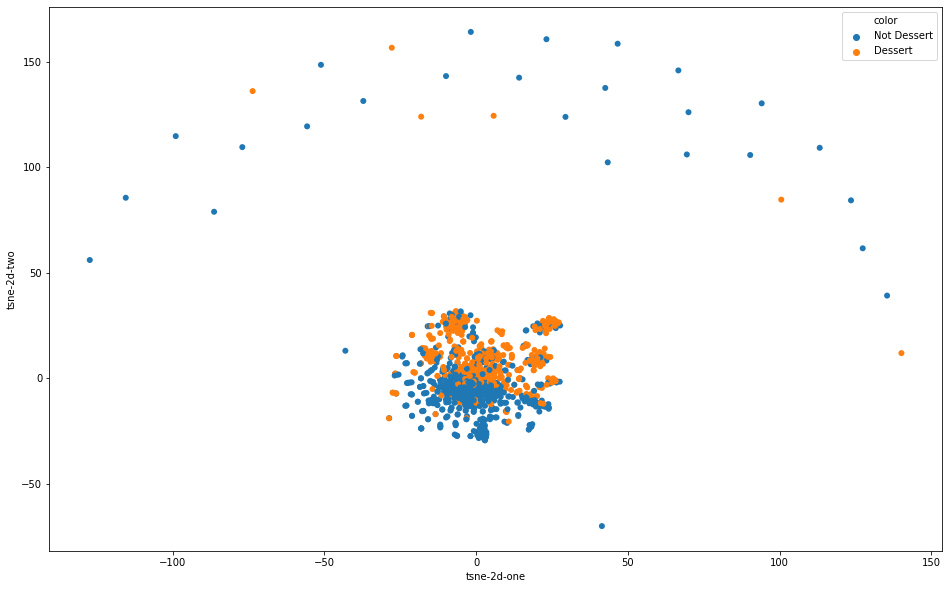

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
#recipe_df["tsne-2d-one"] = tsne_results[:, 0]
#recipe_df["tsne-2d-two"] = tsne_results[:, 1]
#tsne_1 = tsne_results[:, 0]
epi_vec["color"] = epi_vec["tags"].apply(lambda x: "Dessert" if "Dessert" in x else "Not Dessert")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=epi_vec, hue="color", linewidth=0)
plt.show()

In [ ]:
## Here I'm just exploring outliers in the t-SNE
#sample_df = recipe_df.loc[recipe_df["tsne-2d-two"] >= 50]
#drop_cols = sample_df.columns[(sample_df == 0).sum() == sample_df.shape[0]]
#sample_df.drop(drop_cols, axis=1, inplace=True)
#sample_df.columns.unique().values
#sample_df.head(15)

In [ ]:
#sample_df.columns.unique().values